In [1]:
from google.colab import drive
import jax.numpy as jnp
from jax.nn import swish, hard_swish, relu
from jax import grad, jit, vmap, value_and_grad, jacfwd
from jax.experimental import optimizers
from jax import random
from math import pi
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import sys
import time
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from scipy import interpolate
from mpl_toolkits import mplot3d

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def subsample_vector(inp, scale):
  ssv = np.zeros((int(len(inp)/scale), ))
  for i in range(0, len(inp), scale):
    b = int(i/scale)
    ssv[b] = inp[i]
  return ssv

def subsample_matrix(inp, scale):
  ssm = np.zeros([int(len(inp[:,0,0])/scale), int(len(inp[0,:,0])/scale), int(len(inp[0,0,:])/scale)])
  for i in range(0, len(inp[:,0,0]) , scale ):
    for j in range(0, len(inp[0,:,0]) , scale ):
      for k in range(0, len(inp[0,0,:]) , scale ):
        ssm[int(i/scale), int(j/scale), int(k/scale)] = inp[i, j, k]
  return ssm

In [3]:
def random_layer_params(m, n, key):
  w_key, b_key = random.split(key)
  scale = jnp.sqrt(2.0/m) # HE Initialisation
  #scale = jnp.sqrt(6.0/m)
  return scale * random.normal(w_key, (n, m), jnp.float64), scale * random.normal(b_key, (n,), jnp.float64) #use for swish
  #return random.uniform(w_key, (n, m), jnp.float32, -scale, scale), random.uniform(b_key, (n,), jnp.float32, -scale, scale) #use for sin

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [4]:
#NN 
def fx(params, x, y, t):
  # per-example predictions
  activations = jnp.hstack([x, y, t])
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs) #better than sin or tanh
    #activations = 0.5*jnp.sin(outputs)
  
  final_w, final_b = params[-1]
  func =  jnp.dot(final_w, activations) + final_b
  funcc = func[0]
  return funcc.reshape()

def fy(params, x, y, t):
  # per-example predictions
  activations = jnp.hstack([x, y, t])
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs) #better than sin or tanh
    #activations = 0.5*jnp.sin(outputs)
  
  final_w, final_b = params[-1]
  func =  jnp.dot(final_w, activations) + final_b
  funcc = func[1]
  return funcc.reshape()
  
def fyfx(params, x, y, t):
  return grad(fy, 1)(params, x, y, t) - grad(fx, 2)(params, x, y, t)
  

In [5]:
def residue_f_con_cont(params, x, y, t): 
  a = jnp.square(grad(fx, 1)(params, x, y, t) + grad(fy, 2)(params, x, y, t))
  return a   

def residue_f_con_mom(params, x, y, t):
  u_x = fx(params, x, y, t)
  u_y = fy(params, x, y, t)
  nu = 0.01

  a = jnp.square(nu*(grad(grad(fyfx, 1), 1)(params, x, y, t) + grad(grad(fyfx, 2), 2)(params, x, y, t)) - (u_x*grad(fyfx, 1)(params, x, y, t) + u_y*grad(fyfx, 2)(params, x, y, t)) - grad(fyfx, 3)(params, x, y, t))
  return a

def residue_f_con(params, x, y, t):
  u_x = fx(params, x, y, t)
  u_y = fy(params, x, y, t)
  nu = 0.01
  
  a = jnp.square(grad(fx, 1)(params, x, y, t) + grad(fy, 2)(params, x, y, t))
  b = jnp.square(nu*(grad(grad(fyfx, 1), 1)(params, x, y, t) + grad(grad(fyfx, 2), 2)(params, x, y, t)) - (u_x*grad(fyfx, 1)(params, x, y, t) + u_y*grad(fyfx, 2)(params, x, y, t)) - grad(fyfx, 3)(params, x, y, t))
  return a + b


In [6]:
batched_fx = vmap(fx, in_axes=(None, 0, 0, 0))
batched_fy = vmap(fy, in_axes=(None, 0, 0, 0))

batched_fyfx = vmap(fyfx, in_axes=(None, 0, 0, 0))

batched_residue_f_con = vmap(residue_f_con, in_axes=(None, 0, 0, 0))
batched_residue_f_con_cont = vmap(residue_f_con_cont, in_axes=(None, 0, 0, 0))
batched_residue_f_con_mom = vmap(residue_f_con_mom, in_axes=(None, 0, 0, 0))

In [7]:
def nn_data_loss_noicbc(params, x_d, y_d, t_d, x_dat, y_dat, t_dat, v_dat, res_wt, reg_wt):  ##what are x_d and y_d, res_wt and reg_wt

  #reg_loss = 0.0
  #for w, b in params:
  #  reg_loss = reg_loss  + jnp.linalg.norm(w)
  #  reg_loss = reg_loss + jnp.linalg.norm(b)
 
  residue = batched_residue_f_con(params, x_d, y_d, t_d)
  vel_zero = jnp.square(batched_fx(params, x_d, y_d, t_d)) + jnp.square(batched_fy(params, x_d, y_d, t_d))
  residue_loss = jnp.mean(jnp.minimum(residue, vel_zero))
  data_loss = jnp.mean(jnp.square(batched_fx(params, x_dat, y_dat, t_dat) - v_dat[:,0]) + 31.2*jnp.square(batched_fy(params, x_dat, y_dat, t_dat) - v_dat[:,1]))  
  loss = res_wt*(residue_loss) + (1.0 - res_wt)*(data_loss) #+ reg_wt*reg_loss
  return loss

In [8]:
@jit
def update_data_noicbc(params, x_d, y_d, t_d, x_dat, y_dat, t_dat, v_dat, res_wt, reg_wt, opt_state): ##what is opt_state?
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(nn_data_loss_noicbc)(params, x_d, y_d, t_d, x_dat, y_dat, t_dat, v_dat, res_wt, reg_wt)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value  ##what does this function do and where does opt_update come from

In [9]:
def accuracy(ux, uy, ux_r, uy_r):
  ex = np.linalg.norm(ux - ux_r)/np.linalg.norm(ux_r)
  ey = np.linalg.norm(uy - uy_r)/np.linalg.norm(uy_r)
  e_av = (ex + ey)/2
  print('Accuracy_x =', np.round(100 - ex*100, 2),'%,', 'Accuracy_y =' ,np.round(100 - ey*100, 2), '%,', 'Accuracy_average =', np.round(100 - e_av*100, 2), '%')
  return 

In [10]:
x_dat, y_dat, t_dat = np.meshgrid(np.linspace(-1.1, 1.1, 400), np.linspace(-0.22, 0.22, 80), np.linspace(0, 0.29, 30))
print(np.shape(x_dat))

(80, 400, 30)


In [11]:
x_dat_ss_2 = subsample_matrix(x_dat, 2)
y_dat_ss_2 = subsample_matrix(y_dat, 2)
t_dat_ss_2 = subsample_matrix(t_dat, 2)

#x_dat_ss_4 = subsample_matrix(x_dat, 4)
#y_dat_ss_4 = subsample_matrix(y_dat, 4)
#t_dat_ss_4 = subsample_matrix(t_dat, 4)

x_dat_ss_5 = subsample_matrix(x_dat, 5)
y_dat_ss_5 = subsample_matrix(y_dat, 5)
t_dat_ss_5 = subsample_matrix(t_dat, 5)

#x_dat_ss_8 = subsample_matrix(x_dat, 8)
#y_dat_ss_8 = subsample_matrix(y_dat, 8)
#t_dat_ss_8 = subsample_matrix(t_dat, 8)

x_dat_ss_10 = subsample_matrix(x_dat, 10)
y_dat_ss_10 = subsample_matrix(y_dat, 10)
t_dat_ss_10 = subsample_matrix(t_dat, 10)

#x_dat_ss_20 = subsample_matrix(x_dat, 20)
#y_dat_ss_20 = subsample_matrix(y_dat, 20)
#t_dat_ss_20 = subsample_matrix(t_dat, 20)

In [12]:
x_datt = x_dat
y_datt = y_dat
t_datt = t_dat

x_dat = x_dat.flatten()
y_dat = y_dat.flatten()
t_dat = t_dat.flatten()

In [13]:
ux = np.load('/content/gdrive/My Drive/2D_UNSTEADY_NSTOKES/ux.npy', allow_pickle=True)
uy = np.load('/content/gdrive/My Drive/2D_UNSTEADY_NSTOKES/uy.npy', allow_pickle=True)
p = np.load('/content/gdrive/My Drive/2D_UNSTEADY_NSTOKES/p.npy', allow_pickle=True)

uxr = ux
uyr = uy

ux_ss_2 = subsample_matrix(ux, 2)
uy_ss_2 = subsample_matrix(uy, 2)

#ux_ss_4 = subsample_matrix(ux, 4)
#uy_ss_4 = subsample_matrix(uy, 4)

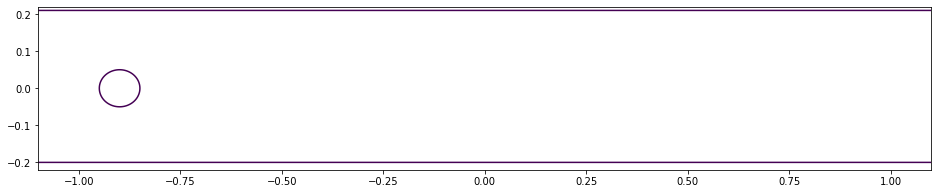

In [14]:
N = [1024,1024]
x = np.linspace(-1.1, 1.1, N[0]+1)
y = np.linspace(-0.22,0.22,N[1]+1)
x_dom,y_dom = np.meshgrid(x,y)

# level-set function for the cylinder and the wind-tunnel walls
phi = np.zeros_like(x_dom)
for i in range(N[0]+1):
    for j in range(N[1]+1):
        if   y_dom[i,j] > 0 and (0.21-y_dom[i,j]) < 0.05:
            phi[i,j] = -0.205+np.sqrt((y_dom[i,j]-0.005)**2)
        elif y_dom[i,j] < 0 and (0.20+y_dom[i,j]) < 0.05:
            phi[i,j] = -0.205+np.sqrt((y_dom[i,j]-0.005)**2)
        elif np.abs(y_dom[i,j]) < 0.15:
            phi[i,j] = 0.05 - np.sqrt((x_dom[i,j]+0.9)**2+(y_dom[i,j]-0)**2)
        else:
            phi[i,j] = -0.1

fig, axs = plt.subplots(1, 1, figsize=(16, 3))
axs.contour(x_dom,y_dom,phi,levels=[0.])

Text(0, 0.5, 'y-position')

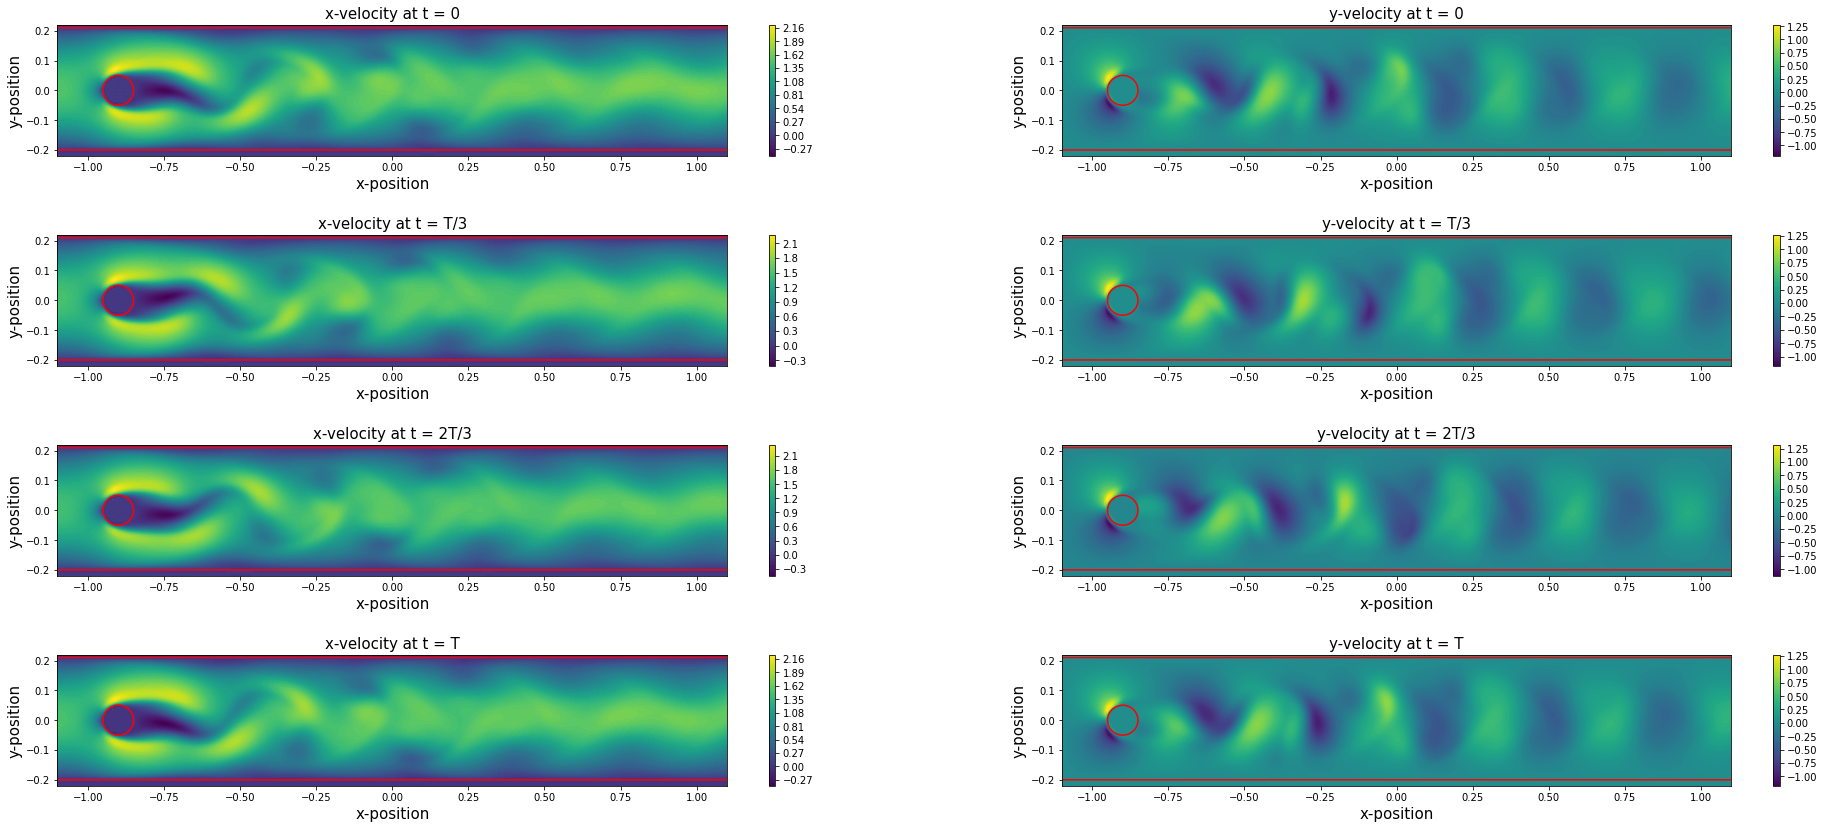

In [15]:
x, y = np.meshgrid(np.linspace(-1.1, 1.1, 400), np.linspace(-0.22, 0.22, 80))

fig, axs = plt.subplots(4, 2, figsize=(33, 14))

axs_0_0 = axs[0,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0,0])
axs[0,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_0 = axs[1,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 9].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1,0])
axs[1,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_0 = axs[2,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 19].flatten(), 100)
fig.colorbar(axs_2_0, ax=axs[2,0])
axs[2,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_0 = axs[3,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 29].flatten(), 100)
fig.colorbar(axs_3_0, ax=axs[3,0])
axs[3,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_0_1 = axs[0,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0,1])
axs[0,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_1 = axs[1,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 9].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1,1])
axs[1,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_1 = axs[2,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 19].flatten(), 100)
fig.colorbar(axs_2_1, ax=axs[2,1])
axs[2,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_1 = axs[3,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 29].flatten(), 100)
fig.colorbar(axs_3_1, ax=axs[3,1])
axs[3,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

fig.subplots_adjust(hspace = 0.6)

axs[0,0].set_title('x-velocity at t = 0', size =15)
axs[1,0].set_title('x-velocity at t = T/3', size =15)
axs[2,0].set_title('x-velocity at t = 2T/3', size =15)
axs[3,0].set_title('x-velocity at t = T', size =15)

axs[0,0].set_xlabel('x-position', size =15)
axs[1,0].set_xlabel('x-position', size =15)
axs[2,0].set_xlabel('x-position', size =15)
axs[3,0].set_xlabel('x-position', size =15)

axs[0,0].set_ylabel('y-position', size =15)
axs[1,0].set_ylabel('y-position', size =15)
axs[2,0].set_ylabel('y-position', size =15)
axs[3,0].set_ylabel('y-position', size =15)

axs[0,1].set_title('y-velocity at t = 0', size =15)
axs[1,1].set_title('y-velocity at t = T/3', size =15)
axs[2,1].set_title('y-velocity at t = 2T/3', size =15)
axs[3,1].set_title('y-velocity at t = T', size =15)

axs[0,1].set_xlabel('x-position', size =15)
axs[1,1].set_xlabel('x-position', size =15)
axs[2,1].set_xlabel('x-position', size =15)
axs[3,1].set_xlabel('x-position', size =15)

axs[0,1].set_ylabel('y-position', size =15)
axs[1,1].set_ylabel('y-position', size =15)
axs[2,1].set_ylabel('y-position', size =15)
axs[3,1].set_ylabel('y-position', size =15)

In [16]:
spacing_x = 0.0055
spacing_y = 0.0055
dxdy = spacing_x * spacing_y
area = 0.968
SNR = 3

variance_x_list = np.zeros((320))
variance_y_list = np.zeros((320))

for i in tqdm(range(30)):

  variance_x = np.square((np.sum(np.abs(ux[:,:,i])) * dxdy * (1/area)))/SNR
  variance_y = np.square((np.sum(np.abs(uy[:,:,i])) * dxdy * (1/area)))/SNR

  variance_x_list[i] = variance_x
  variance_y_list[i] = variance_y

  k1 = random.PRNGKey(i)
  k2 = random.PRNGKey(i+9)

  ux[:,:,i] = np.add(ux[:,:,i], random.normal(k1, ux[:,:,i].shape, jnp.float64) * np.sqrt(variance_x))
  uy[:,:,i] = np.add(uy[:,:,i], random.normal(k2, uy[:,:,i].shape, jnp.float64) * np.sqrt(variance_y))

average_variance_x = np.mean(variance_x_list)
average_variance_y = np.mean(variance_y_list)

print('Average Inverse Variance in x-direction: ' + str(1/average_variance_x))
print('Average Inverse Variance in y-direction: ' + str(1/average_variance_y))


Average Inverse Variance in x-direction: 39.68326259187406
Average Inverse Variance in y-direction: 1239.0668252380988


In [17]:
v_dat = jnp.column_stack([ux.flatten(), uy.flatten()])

Text(0, 0.5, 'y-position')

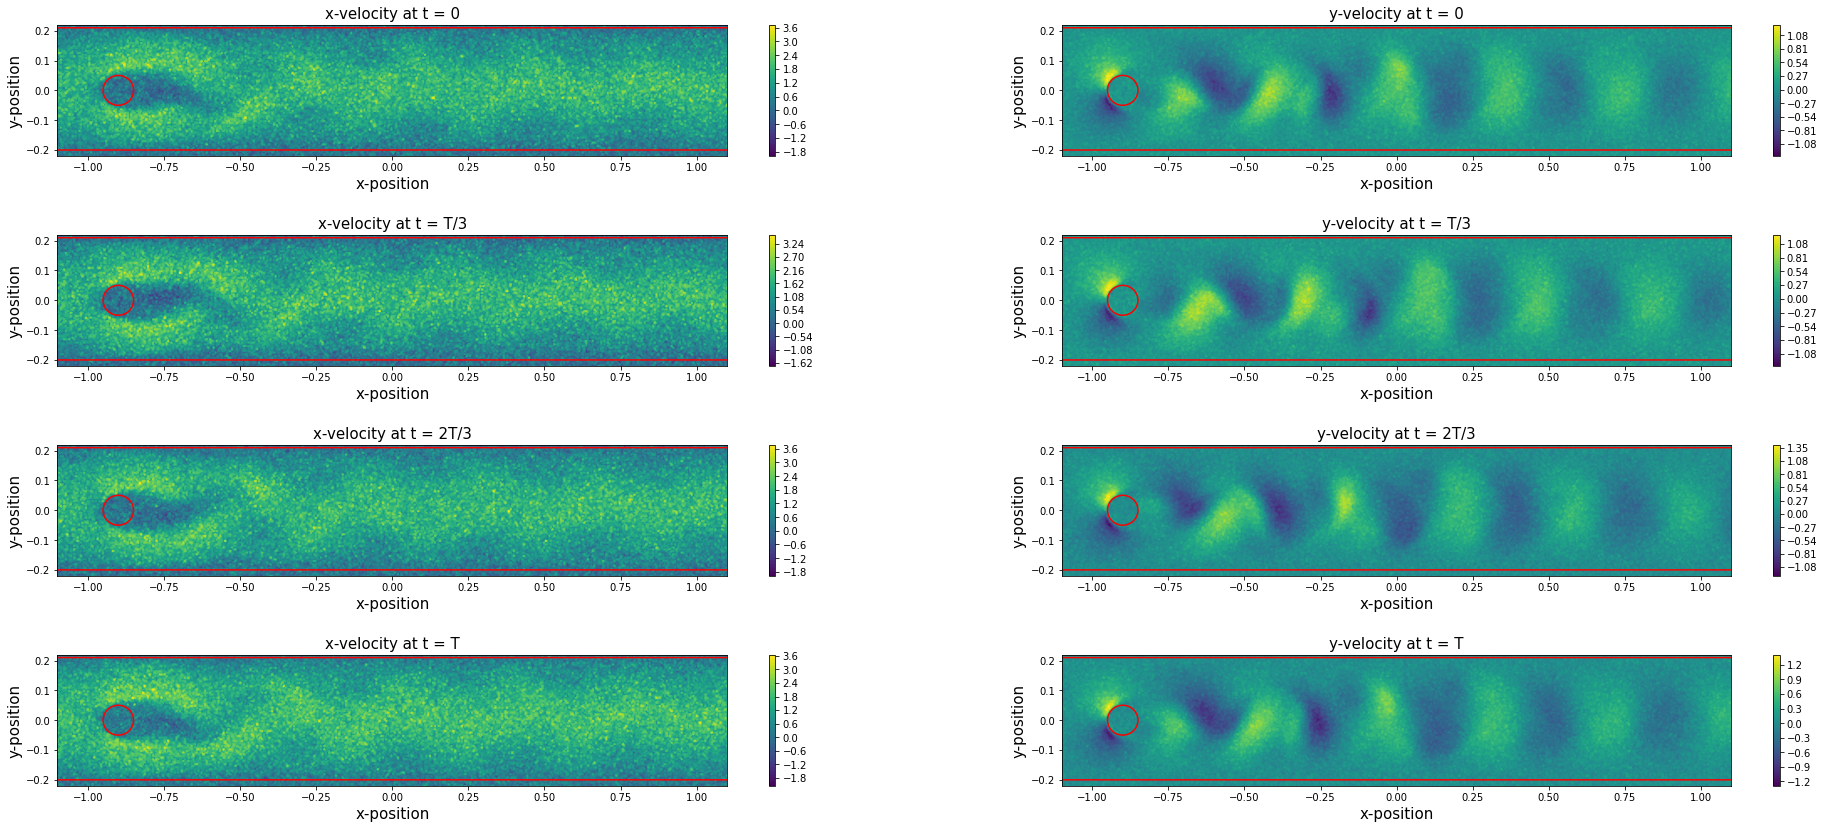

In [18]:
x, y = np.meshgrid(np.linspace(-1.1, 1.1, 400), np.linspace(-0.22, 0.22, 80))

fig, axs = plt.subplots(4, 2, figsize=(33, 14))

axs_0_0 = axs[0,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0,0])
axs[0,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_0 = axs[1,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 9].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1,0])
axs[1,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_0 = axs[2,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 19].flatten(), 100)
fig.colorbar(axs_2_0, ax=axs[2,0])
axs[2,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_0 = axs[3,0].tricontourf(x.flatten(), y.flatten() , ux[:, :, 29].flatten(), 100)
fig.colorbar(axs_3_0, ax=axs[3,0])
axs[3,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_0_1 = axs[0,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0,1])
axs[0,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_1 = axs[1,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 9].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1,1])
axs[1,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_1 = axs[2,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 19].flatten(), 100)
fig.colorbar(axs_2_1, ax=axs[2,1])
axs[2,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_1 = axs[3,1].tricontourf(x.flatten(), y.flatten() , uy[:, :, 29].flatten(), 100)
fig.colorbar(axs_3_1, ax=axs[3,1])
axs[3,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

fig.subplots_adjust(hspace = 0.6)

axs[0,0].set_title('x-velocity at t = 0', size =15)
axs[1,0].set_title('x-velocity at t = T/3', size =15)
axs[2,0].set_title('x-velocity at t = 2T/3', size =15)
axs[3,0].set_title('x-velocity at t = T', size =15)

axs[0,0].set_xlabel('x-position', size =15)
axs[1,0].set_xlabel('x-position', size =15)
axs[2,0].set_xlabel('x-position', size =15)
axs[3,0].set_xlabel('x-position', size =15)

axs[0,0].set_ylabel('y-position', size =15)
axs[1,0].set_ylabel('y-position', size =15)
axs[2,0].set_ylabel('y-position', size =15)
axs[3,0].set_ylabel('y-position', size =15)

axs[0,1].set_title('y-velocity at t = 0', size =15)
axs[1,1].set_title('y-velocity at t = T/3', size =15)
axs[2,1].set_title('y-velocity at t = 2T/3', size =15)
axs[3,1].set_title('y-velocity at t = T', size =15)

axs[0,1].set_xlabel('x-position', size =15)
axs[1,1].set_xlabel('x-position', size =15)
axs[2,1].set_xlabel('x-position', size =15)
axs[3,1].set_xlabel('x-position', size =15)

axs[0,1].set_ylabel('y-position', size =15)
axs[1,1].set_ylabel('y-position', size =15)
axs[2,1].set_ylabel('y-position', size =15)
axs[3,1].set_ylabel('y-position', size =15)

In [19]:
#initial guess fit data

num_epochs = 15001
layer_sizes = [3, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 2] 
#layer_sizes = [3, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 2] 
#layer_sizes = [3, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 2] 
#layer_sizes = [3, 500, 500, 500, 500, 500, 500, 500, 500, 2]
params = init_network_params(layer_sizes, random.PRNGKey(78))

step_size = 1e-3
opt_init, opt_update, get_params = optimizers.sm3(step_size)
opt_state = opt_init(params)
reg_wt = 0
res_wt = 0

loss = 0
loss_history = []

x, y, t = np.meshgrid(np.linspace(-1.1, 1.1, 400), np.linspace(-0.22, 0.22, 80), np.linspace(0, 0.29, 30))

for i in tqdm(range(num_epochs)):
  
  if ((i% 100 == 0)):

    print()

    if ((i%1000 == 0)):
      !nvidia-smi
    
    #if i >= 6000:
    #  res_wt = 0.05

    plt.plot(loss_history[100:], 'k' )
    plt.show()

    ux_f = batched_fx(params, x.flatten(), y.flatten(), t.flatten())
    ux_f = ux_f.reshape(80, 400, 30)

    uy_f = batched_fy(params, x.flatten(), y.flatten(), t.flatten())
    uy_f = uy_f.reshape(80, 400, 30)

    fig, axs = plt.subplots(4, 2, figsize=(33, 14))

    axs_0_0 = axs[0,0].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , ux_f[:, :, 0].flatten(), 100)
    fig.colorbar(axs_0_0, ax=axs[0,0])
    axs[0,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_1_0 = axs[1,0].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , ux_f[:, :, 9].flatten(), 100)
    fig.colorbar(axs_1_0, ax=axs[1,0])
    axs[1,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_2_0 = axs[2,0].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , ux_f[:, :, 19].flatten(), 100)
    fig.colorbar(axs_2_0, ax=axs[2,0])
    axs[2,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_3_0 = axs[3,0].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , ux_f[:, :, 29].flatten(), 100)
    fig.colorbar(axs_3_0, ax=axs[3,0])
    axs[3,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_0_1 = axs[0,1].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , uy_f[:, :, 0].flatten(), 100)
    fig.colorbar(axs_0_1, ax=axs[0,1])
    axs[0,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_1_1 = axs[1,1].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , uy_f[:, :, 9].flatten(), 100)
    fig.colorbar(axs_1_1, ax=axs[1,1])
    axs[1,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_2_1 = axs[2,1].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , uy_f[:, :, 19].flatten(), 100)
    fig.colorbar(axs_2_1, ax=axs[2,1])
    axs[2,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    axs_3_1 = axs[3,1].tricontourf(x[:,:, 0].flatten(), y[:,:, 0].flatten() , uy_f[:, :, 29].flatten(), 100)
    fig.colorbar(axs_3_1, ax=axs[3,1])
    axs[3,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

    fig.subplots_adjust(hspace = 0.6)

    axs[0,0].set_title('x-velocity at t = 0, ' + 'epoch ' + str(i), size =15)
    axs[1,0].set_title('x-velocity at t = T/3, ' + 'epoch ' + str(i), size =15)
    axs[2,0].set_title('x-velocity at t = 2T/3, ' + 'epoch ' + str(i), size =15)
    axs[3,0].set_title('x-velocity at t = T, ' + 'epoch ' + str(i), size =15)

    axs[0,0].set_xlabel('x-position', size =15)
    axs[1,0].set_xlabel('x-position', size =15)
    axs[2,0].set_xlabel('x-position', size =15)
    axs[3,0].set_xlabel('x-position', size =15)

    axs[0,0].set_ylabel('y-position', size =15)
    axs[1,0].set_ylabel('y-position', size =15)
    axs[2,0].set_ylabel('y-position', size =15)
    axs[3,0].set_ylabel('y-position', size =15)

    axs[0,1].set_title('y-velocity at t = 0, ' + 'epoch ' + str(i), size =15)
    axs[1,1].set_title('y-velocity at t = T/3, ' + 'epoch ' + str(i), size =15)
    axs[2,1].set_title('y-velocity at t = 2T/3, ' + 'epoch ' + str(i), size =15)
    axs[3,1].set_title('y-velocity at t = T, ' + 'epoch ' + str(i), size =15)

    axs[0,1].set_xlabel('x-position', size =15)
    axs[1,1].set_xlabel('x-position', size =15)
    axs[2,1].set_xlabel('x-position', size =15)
    axs[3,1].set_xlabel('x-position', size =15)

    axs[0,1].set_ylabel('y-position', size =15)
    axs[1,1].set_ylabel('y-position', size =15)
    axs[2,1].set_ylabel('y-position', size =15)
    axs[3,1].set_ylabel('y-position', size =15)

    plt.show()

    res_wt = 1 - jnp.exp(-i/300000.0)

    print('i:', i)
    print('loss:', loss)
    print('res_wt:', res_wt)
    
    np.save('/content/gdrive/My Drive/2D_UNSTEADY_NSTOKES/params_exp.npy', params, allow_pickle=True)
    np.save('/content/gdrive/My Drive/2D_UNSTEADY_NSTOKES/loss_history_exp.npy', loss_history, allow_pickle=True)

  key = random.PRNGKey(i)
  key2 = random.PRNGKey(i+3)
  key3 = random.PRNGKey(i+6)
  x_d = random.uniform(key, (512,), jnp.float64, -1.1, 1.1)
  y_d = random.uniform(key2, (512,), jnp.float64, -0.22, 0.22)
  t_d = random.uniform(key3, (512,), jnp.float64, 0, 0.29)

  indices = random.choice(key, jnp.arange(x_dat.shape[0]), shape=(2048,), replace=False, p=None)
  x_dat_sample = x_dat[indices]
  y_dat_sample = y_dat[indices]
  t_dat_sample = t_dat[indices]
  v_dat_sample = v_dat[indices, :]

  params, opt_state, loss = update_data_noicbc(params, x_d, y_d, t_d, x_dat_sample, y_dat_sample, t_dat_sample, v_dat_sample, res_wt, reg_wt, opt_state)
  loss_history.append(loss)

  pass

Output hidden; open in https://colab.research.google.com to view.

In [17]:
params = np.load('/content/gdrive/My Drive/2D_UNSTEADY_NSTOKES/params_exp.npy', allow_pickle=True)
#params_nrl = np.load('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P01/params_nrl.npy', allow_pickle=True)

#params_p is for residual loss of 3%, SNR 3, (80 X 400 X 30t), 30 LAYERS, 225 NODES PER LAYER
#params_p1 is for residual loss of 1%, SNR 3, (80 X 400 X 30t), 30 LAYERS, 225 NODES PER LAYER
#params_p2 is for residual loss of 5%, SNR 3, (80 X 400 X 30t), 30 LAYERS, 225 NODES PER LAYER
#params_exp is for residual loss of exp variation, SNR 3, (80 X 400 X 30t), 30 LAYERS, 225 NODES PER LAYER

Text(0, 0.5, 'y-position')

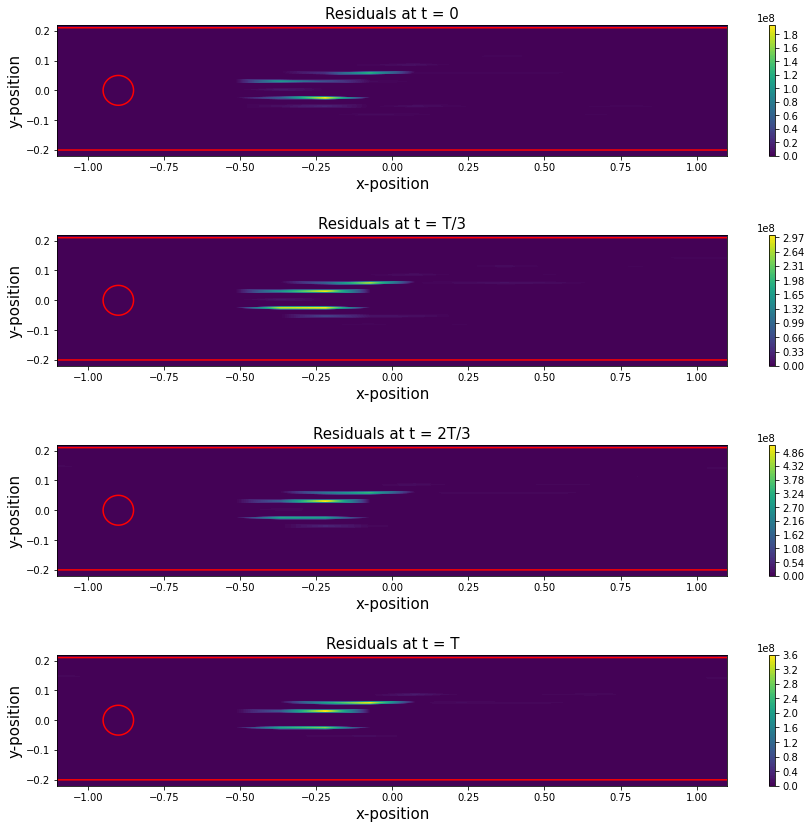

In [21]:
residuals = batched_residue_f_con(params, x_dat_ss_5.flatten(), y_dat_ss_5.flatten(), t_dat_ss_5.flatten())
residuals = residuals.reshape(16, 80, 6)

x, y = np.meshgrid(np.linspace(-1.1, 1.1, 16), np.linspace(-0.22, 0.22, 80))

fig, axs = plt.subplots(4, 1, figsize=(15, 14))

axs_0_0 = axs[0].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0])
axs[0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_0 = axs[1].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 2].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1])
axs[1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_0 = axs[2].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 4].flatten(), 100)
fig.colorbar(axs_2_0, ax=axs[2])
axs[2].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_0 = axs[3].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 6].flatten(), 100)
fig.colorbar(axs_3_0, ax=axs[3])
axs[3].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

fig.subplots_adjust(hspace = 0.6)

axs[0].set_title('Residuals at t = 0', size =15)
axs[1].set_title('Residuals at t = T/3', size =15)
axs[2].set_title('Residuals at t = 2T/3', size =15)
axs[3].set_title('Residuals at t = T', size =15)

axs[0].set_xlabel('x-position', size =15)
axs[1].set_xlabel('x-position', size =15)
axs[2].set_xlabel('x-position', size =15)
axs[3].set_xlabel('x-position', size =15)

axs[0].set_ylabel('y-position', size =15)
axs[1].set_ylabel('y-position', size =15)
axs[2].set_ylabel('y-position', size =15)
axs[3].set_ylabel('y-position', size =15)

Text(0, 0.5, 'y-position')

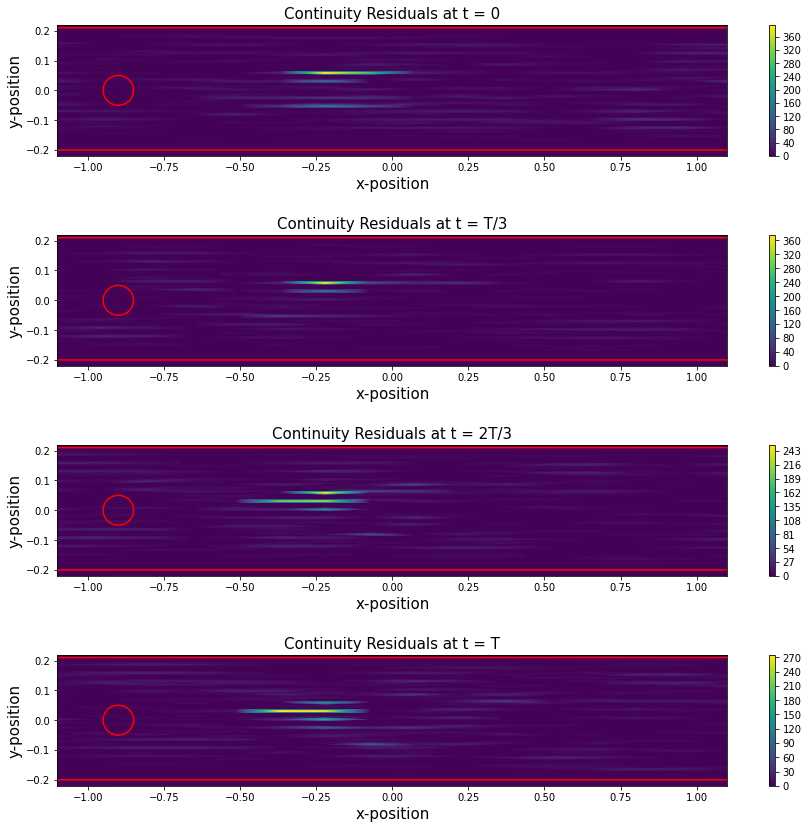

In [22]:
residuals = batched_residue_f_con_cont(params, x_dat_ss_5.flatten(), y_dat_ss_5.flatten(), t_dat_ss_5.flatten())
residuals = residuals.reshape(16, 80, 6)

x, y = np.meshgrid(np.linspace(-1.1, 1.1, 16), np.linspace(-0.22, 0.22, 80))

fig, axs = plt.subplots(4, 1, figsize=(15, 14))

axs_0_0 = axs[0].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0])
axs[0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_0 = axs[1].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 2].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1])
axs[1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_0 = axs[2].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 4].flatten(), 100)
fig.colorbar(axs_2_0, ax=axs[2])
axs[2].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_0 = axs[3].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 6].flatten(), 100)
fig.colorbar(axs_3_0, ax=axs[3])
axs[3].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

fig.subplots_adjust(hspace = 0.6)

axs[0].set_title('Continuity Residuals at t = 0', size =15)
axs[1].set_title('Continuity Residuals at t = T/3', size =15)
axs[2].set_title('Continuity Residuals at t = 2T/3', size =15)
axs[3].set_title('Continuity Residuals at t = T', size =15)

axs[0].set_xlabel('x-position', size =15)
axs[1].set_xlabel('x-position', size =15)
axs[2].set_xlabel('x-position', size =15)
axs[3].set_xlabel('x-position', size =15)

axs[0].set_ylabel('y-position', size =15)
axs[1].set_ylabel('y-position', size =15)
axs[2].set_ylabel('y-position', size =15)
axs[3].set_ylabel('y-position', size =15)

Text(0, 0.5, 'y-position')

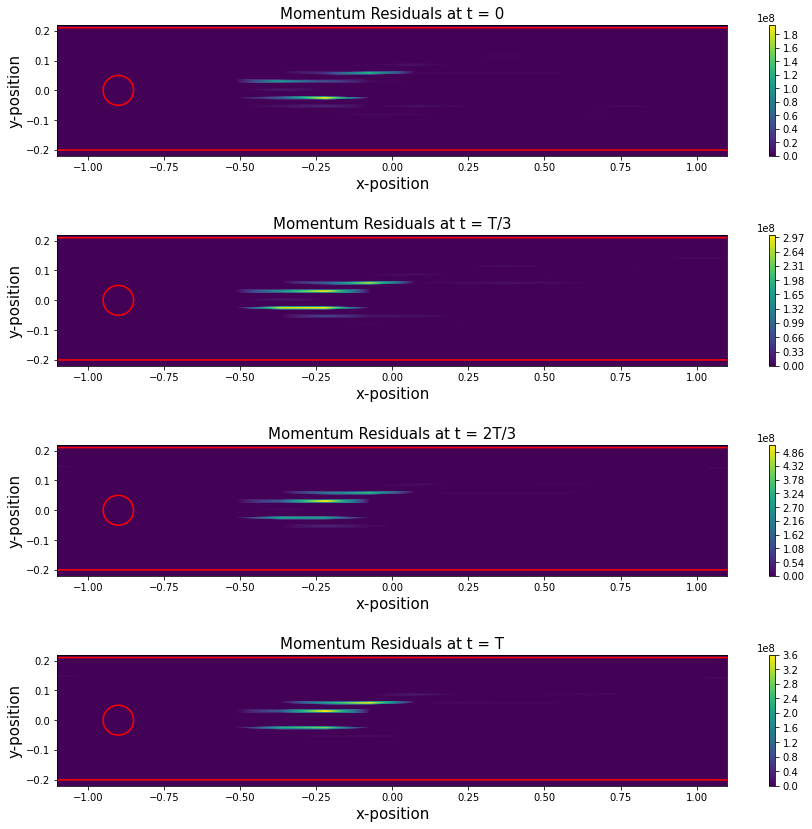

In [23]:
residuals = batched_residue_f_con_mom(params, x_dat_ss_5.flatten(), y_dat_ss_5.flatten(), t_dat_ss_5.flatten())
residuals = residuals.reshape(16, 80, 6)

x, y = np.meshgrid(np.linspace(-1.1, 1.1, 16), np.linspace(-0.22, 0.22, 80))

fig, axs = plt.subplots(4, 1, figsize=(15, 14))

axs_0_0 = axs[0].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0])
axs[0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_0 = axs[1].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 2].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1])
axs[1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_0 = axs[2].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 4].flatten(), 100)
fig.colorbar(axs_2_0, ax=axs[2])
axs[2].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_0 = axs[3].tricontourf(x.flatten(), y.flatten() , residuals[:, :, 6].flatten(), 100)
fig.colorbar(axs_3_0, ax=axs[3])
axs[3].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

fig.subplots_adjust(hspace = 0.6)

axs[0].set_title('Momentum Residuals at t = 0', size =15)
axs[1].set_title('Momentum Residuals at t = T/3', size =15)
axs[2].set_title('Momentum Residuals at t = 2T/3', size =15)
axs[3].set_title('Momentum Residuals at t = T', size =15)

axs[0].set_xlabel('x-position', size =15)
axs[1].set_xlabel('x-position', size =15)
axs[2].set_xlabel('x-position', size =15)
axs[3].set_xlabel('x-position', size =15)

axs[0].set_ylabel('y-position', size =15)
axs[1].set_ylabel('y-position', size =15)
axs[2].set_ylabel('y-position', size =15)
axs[3].set_ylabel('y-position', size =15)

In [18]:
ux_ff = batched_fx(params, x_dat, y_dat, t_dat)
ux_ff = ux_ff.reshape(80, 400, 30)

uy_ff = batched_fy(params, x_dat, y_dat, t_dat)
uy_ff = uy_ff.reshape(80, 400, 30)


u_mag = jnp.sqrt(jnp.square(ux_ff) + jnp.square(uy_ff))

accuracy(ux_ff, uy_ff, uxr, uyr)

Accuracy_x = 90.93 %, Accuracy_y = 88.32 %, Accuracy_average = 89.62 %


Text(0, 0.5, 'y-position')

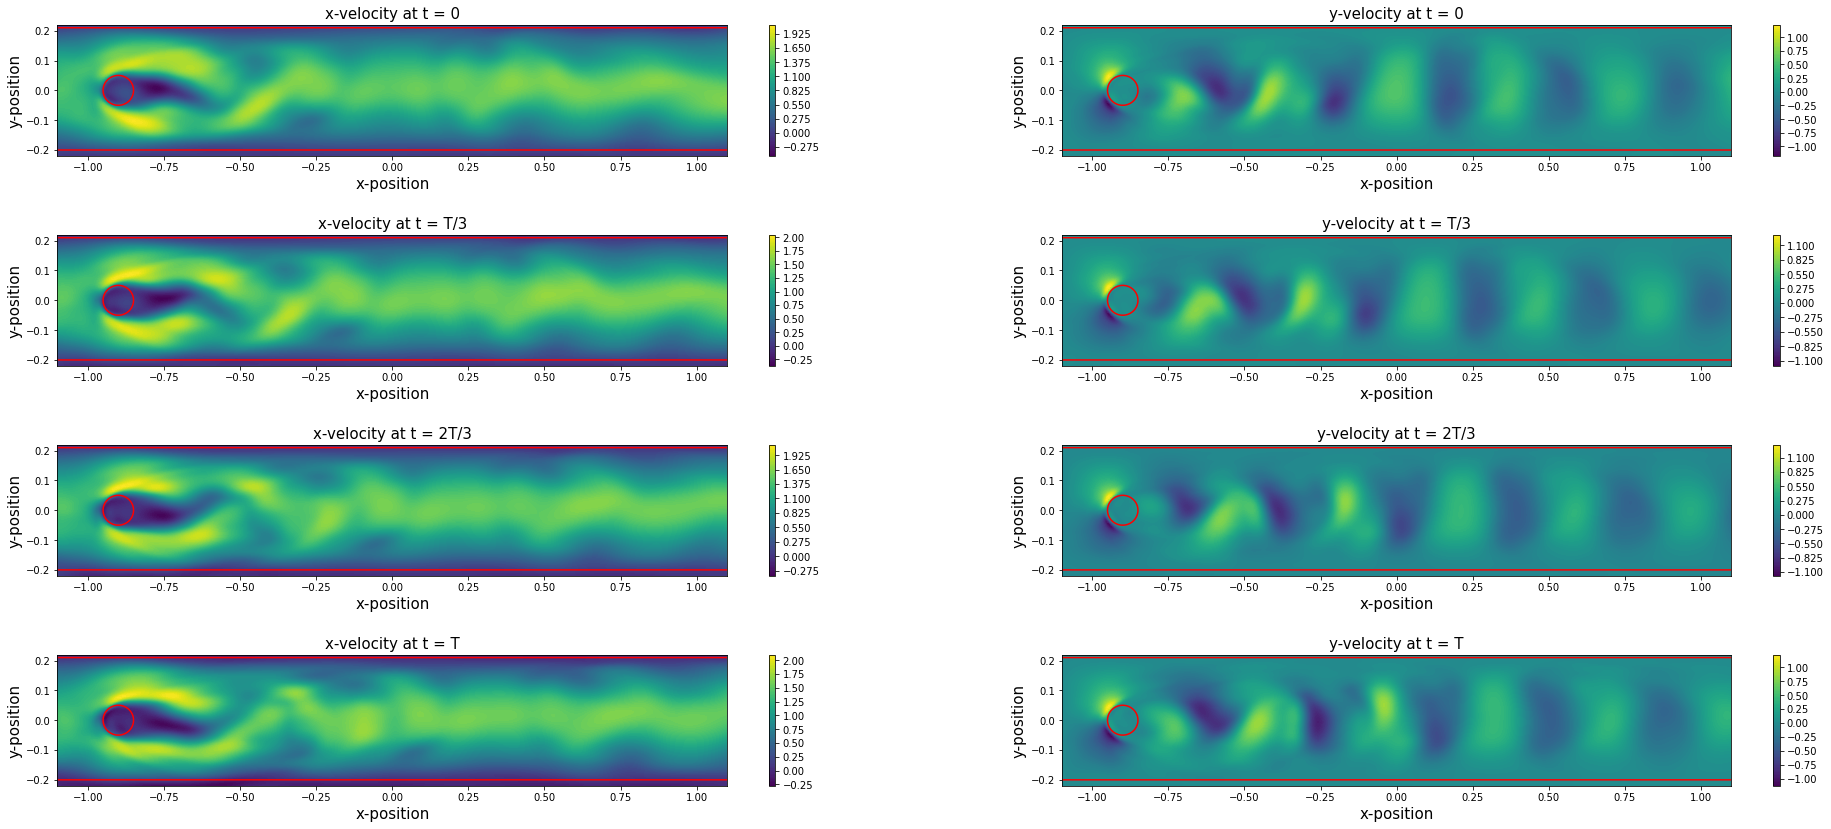

In [25]:
x, y = np.meshgrid(np.linspace(-1.1, 1.1, 400), np.linspace(-0.22, 0.22, 80))

fig, axs = plt.subplots(4, 2, figsize=(33, 14))

axs_0_0 = axs[0,0].tricontourf(x.flatten(), y.flatten() , ux_ff[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0,0])
axs[0,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_0 = axs[1,0].tricontourf(x.flatten(), y.flatten() , ux_ff[:, :, 9].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1,0])
axs[1,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_0 = axs[2,0].tricontourf(x.flatten(), y.flatten() , ux_ff[:, :, 19].flatten(), 100)
fig.colorbar(axs_2_0, ax=axs[2,0])
axs[2,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_0 = axs[3,0].tricontourf(x.flatten(), y.flatten() , ux_ff[:, :, 29].flatten(), 100)
fig.colorbar(axs_3_0, ax=axs[3,0])
axs[3,0].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_0_1 = axs[0,1].tricontourf(x.flatten(), y.flatten() , uy_ff[:, :, 0].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0,1])
axs[0,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_1_1 = axs[1,1].tricontourf(x.flatten(), y.flatten() , uy_ff[:, :, 9].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1,1])
axs[1,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_2_1 = axs[2,1].tricontourf(x.flatten(), y.flatten() , uy_ff[:, :, 19].flatten(), 100)
fig.colorbar(axs_2_1, ax=axs[2,1])
axs[2,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

axs_3_1 = axs[3,1].tricontourf(x.flatten(), y.flatten() , uy_ff[:, :, 29].flatten(), 100)
fig.colorbar(axs_3_1, ax=axs[3,1])
axs[3,1].contour(x_dom,y_dom,phi,levels=[0.], colors = 'red')

fig.subplots_adjust(hspace = 0.6)

axs[0,0].set_title('x-velocity at t = 0', size =15)
axs[1,0].set_title('x-velocity at t = T/3', size =15)
axs[2,0].set_title('x-velocity at t = 2T/3', size =15)
axs[3,0].set_title('x-velocity at t = T', size =15)

axs[0,0].set_xlabel('x-position', size =15)
axs[1,0].set_xlabel('x-position', size =15)
axs[2,0].set_xlabel('x-position', size =15)
axs[3,0].set_xlabel('x-position', size =15)

axs[0,0].set_ylabel('y-position', size =15)
axs[1,0].set_ylabel('y-position', size =15)
axs[2,0].set_ylabel('y-position', size =15)
axs[3,0].set_ylabel('y-position', size =15)

axs[0,1].set_title('y-velocity at t = 0', size =15)
axs[1,1].set_title('y-velocity at t = T/3', size =15)
axs[2,1].set_title('y-velocity at t = 2T/3', size =15)
axs[3,1].set_title('y-velocity at t = T', size =15)

axs[0,1].set_xlabel('x-position', size =15)
axs[1,1].set_xlabel('x-position', size =15)
axs[2,1].set_xlabel('x-position', size =15)
axs[3,1].set_xlabel('x-position', size =15)

axs[0,1].set_ylabel('y-position', size =15)
axs[1,1].set_ylabel('y-position', size =15)
axs[2,1].set_ylabel('y-position', size =15)
axs[3,1].set_ylabel('y-position', size =15)